In [1]:
import fireworks
from fireworks import Message
from fireworks.extensions import IgniteJunction, Experiment
from ignite.metrics import Metric

import torch
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from nonlinear_regression_utils import NonlinearModel, get_data
# from examples.database_example import get_data

/usr/local/lib/python3.5/dist-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))
/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
description = "In this experiment, we are training a polynomial model using least squares regression to fit data generated by a random polynomial."
experiment = Experiment("nonlinear_regression", description=description)

train_set, test_set, params = get_data(n=1000)

model = NonlinearModel()
# model = NonlinearModel(components={'d': [0], 'e':[0]})
# model.freeze(['d','e'])

# Construct training closure and train using ignite
base_loss = torch.nn.MSELoss()
loss = lambda batch: base_loss(batch['y_pred'], batch['y'])
trainer = IgniteJunction(components={'model': model, 'dataset': train_set}, loss=loss, optimizer='Adam', lr=.1, visdom=False)

class ModelSaverMetric(Metric):

    def __init__(self, output_transform=lambda x:x, log_interval=100):
        self.model_state = Message()
        Metric.__init__(self, output_transform=output_transform)
        self.log_interval = log_interval

    def iteration_completed(self, engine):
            iter = (engine.state.iteration-1)
            if iter % self.log_interval == 0:
                current_state = Message.from_objects(deepcopy(engine.state.output['state']))
                current_state['iteration'] = [iter]
                self.model_state = self.model_state.append(current_state)

    def compute(self):
        # Return most recent model state
        l = len(self.model_state)
        return self.model_state[l-1]

    def reset(self):
        pass
    
    def update(self, output):
        pass


In [3]:
model_state_metric = ModelSaverMetric()
model_state_metric.attach(trainer, 'state')

x = Message({'x':np.arange(-10,10,.2)}).to_tensors()

# Run initial evaluation
y_initial = model(x)['y_pred'].detach().numpy()
initial_loss = loss(model(test_set[0:250]))
print("Initial loss on test set: {0}".format(initial_loss))

# Save initial state of model
file_path = experiment.open('initial_model', string_only=True)
initial_state = model.get_state()
Message.from_objects(initial_state).to('json', path=file_path)

trainer.train(max_epochs=200)

final_loss = loss(model(test_set[0:250]))
print("Final loss on test set:: {0}".format(final_loss))


Initial loss on test set: 793325600768.0
Epoch[1] Iteration: 0 Time: 0:00:00 Loss: 1703282737152.00
Epoch[4] Iteration: 100 Time: 0:00:00 Loss: 52878760.00
Epoch[7] Iteration: 200 Time: 0:00:01 Loss: 2321645.25
Epoch[11] Iteration: 300 Time: 0:00:01 Loss: 2253621.00
Epoch[14] Iteration: 400 Time: 0:00:02 Loss: 1385003.12
Epoch[17] Iteration: 500 Time: 0:00:02 Loss: 2780464.00
Epoch[21] Iteration: 600 Time: 0:00:03 Loss: 1674259.62
Epoch[24] Iteration: 700 Time: 0:00:03 Loss: 2056177.25
Epoch[27] Iteration: 800 Time: 0:00:04 Loss: 1903565.25
Epoch[31] Iteration: 900 Time: 0:00:04 Loss: 1971477.75
Epoch[34] Iteration: 1000 Time: 0:00:05 Loss: 1796139.12
Epoch[37] Iteration: 1100 Time: 0:00:06 Loss: 2031930.62
Epoch[41] Iteration: 1200 Time: 0:00:06 Loss: 2946912.00
Epoch[44] Iteration: 1300 Time: 0:00:07 Loss: 1465598.00
Epoch[47] Iteration: 1400 Time: 0:00:07 Loss: 1114673.25
Epoch[51] Iteration: 1500 Time: 0:00:08 Loss: 1152297.62
Epoch[54] Iteration: 1600 Time: 0:00:08 Loss: 1226153.7

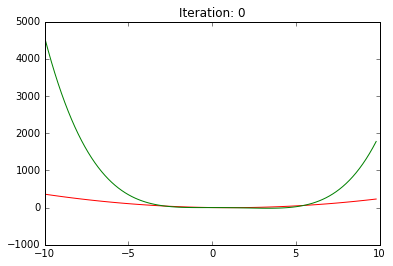

In [4]:
# Visualize functions
true_model = NonlinearModel(components={'a':[params['a']], 'b': [params['b']], 'c': [params['c']], 'd': [0], 'e': [0]})

y_true = true_model(x)['y_pred'].detach().numpy()
y_final = model(x)['y_pred'].detach().numpy()

# Save model states during training
file_path = experiment.open('model_states', string_only=True)
model_states = model_state_metric.model_state
Message.from_objects(initial_state).to('json', path=file_path)

fig, ax = plt.subplots()

def animate(frame):

    current_state = {'internal': frame['internal'][0], 'external': {}}
    model.set_state(current_state)

    y_predicted = model(x)['y_pred'].detach().numpy()
    xdata = list(x['x'].detach().numpy())
    ydata = list(y_predicted)
    ax.clear()
    ax.plot(xdata, list(y_true), 'r')
    ax.plot(xdata, ydata, 'g')
    title = "Iteration: {0}".format(frame['iteration'][0])

    ax.set_title(title)

ani = FuncAnimation(fig, animate, model_state_metric.model_state, interval=1000)
ani.save(experiment.open("models.mp4", string_only=True)) # This will only work if you have ffmpeg installed.
plt.show()
